# Курсовой проект

Загрузите данные по курсам акций Сбербанка за 2020-2021 год и сделайте предсказание курса на январь 2022.

Используйте ансамбль из LSTM/GRU, SARIMA и любых других моделей, которые покажут достаточную точность. Сравните предсказание с фактическими данными.

Дополнительно можно использовать любые другие серии данных (макроэкономических показателей), если они позволяют уточнить прогноз.

Выложите решение в своем репозитории на GitHub и приложите на него ссылку.

Данные: https://video.ittensive.com/time-series/ittensive.time.series.04.csv

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

In [3]:
def smape(A, F):
    return 100*np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

# Подготовка и исследование данных

In [4]:
df = pd.read_csv("https://video.ittensive.com/time-series/ittensive.time.series.04.csv", encoding="windows-1251",
                   delimiter=";", decimal=",", header=0) 
df.columns = list(map(lambda x: x.lower(),(['Дата','Открытие','Макс','Мин','цена'])))
df


,дата,открытие,макс,мин,цена
0,03.01.2020,255.99,258.19,253.70,255.00
1,06.01.2020,254.75,254.84,251.40,253.90
2,08.01.2020,253.57,259.15,253.03,259.15
3,09.01.2020,259.40,261.76,257.01,257.99
4,10.01.2020,257.86,259.25,256.88,258.19
...,...,...,...,...,...
627,27.12.2021,294.76,296.00,293.37,295.59
628,28.12.2021,295.84,297.55,294.18,294.98
629,29.12.2021,295.05,295.55,291.33,293.37
630,30.12.2021,293.60,294.89,291.52,293.39


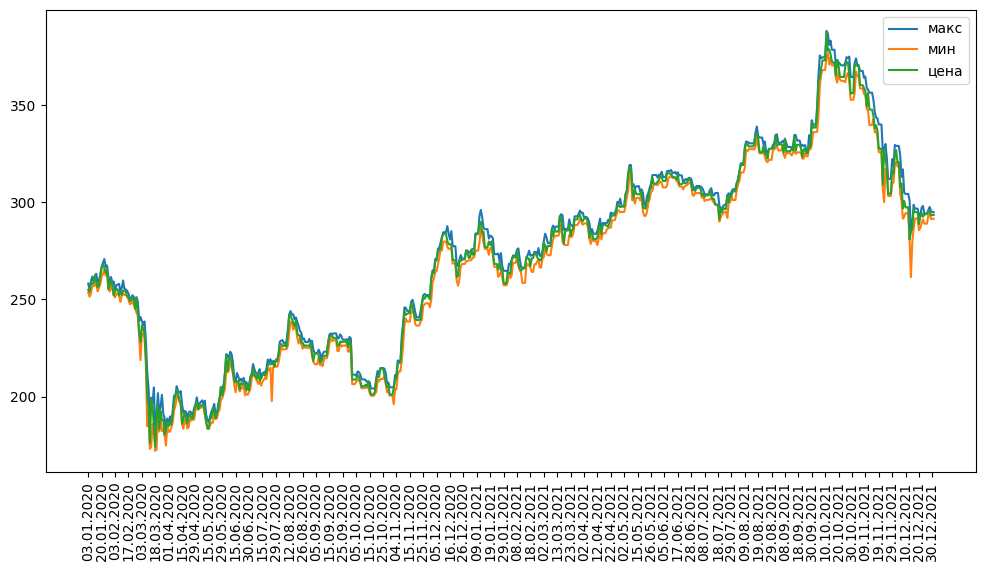

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(df["макс"])
plt.plot(df["мин"])
plt.plot(df["цена"])
plt.xticks(range(0, len(df)+5, 10),
           list(df['дата'][::10].values), rotation="vertical")  # + ['01.02.2021', '01.07.2021', '01.01.2022']
plt.legend(labels=['макс', 'мин','цена'])
plt.show()

In [6]:
# Аугментация данных

data=df.copy()

data = data.reset_index().drop(labels="index", axis=1)[::-1]
data["дата"] = pd.to_datetime(data["дата"])
data["день"] = data["дата"].dt.day
data["wd"] = data["дата"].dt.weekday

data["diff1"] = data["цена"].diff()
for i in range(1, 5):
    data["цена" + str(i)] = data["цена"].shift(i)
    data["diff" + str(i+1)] = data["diff" + str(i)].diff()
data.head()

,дата,открытие,макс,мин,цена,день,wd,diff1,цена1,diff2,цена2,diff3,цена3,diff4,цена4,diff5
631,2021-12-31,293.60,294.89,291.52,293.49,31,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
630,2021-12-30,293.60,294.89,291.52,293.39,30,3,-0.10,293.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN
629,2021-12-29,295.05,295.55,291.33,293.37,29,2,-0.02,293.39,0.08,293.49,NaN,NaN,NaN,NaN,NaN
628,2021-12-28,295.84,297.55,294.18,294.98,28,1,1.61,293.37,1.63,293.39,1.55,293.49,NaN,NaN,NaN
627,2021-12-27,294.76,296.00,293.37,295.59,27,0,0.61,294.98,-1.00,293.37,-2.63,293.39,-4.18,293.49,NaN


# Характеристики ряда. Оценка значимости параметров


In [7]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf,plot_predict
from statsmodels.tsa.stattools import adfuller,pacf,acf

In [8]:
# plot_acf(data["diff1"])
# plt.show()

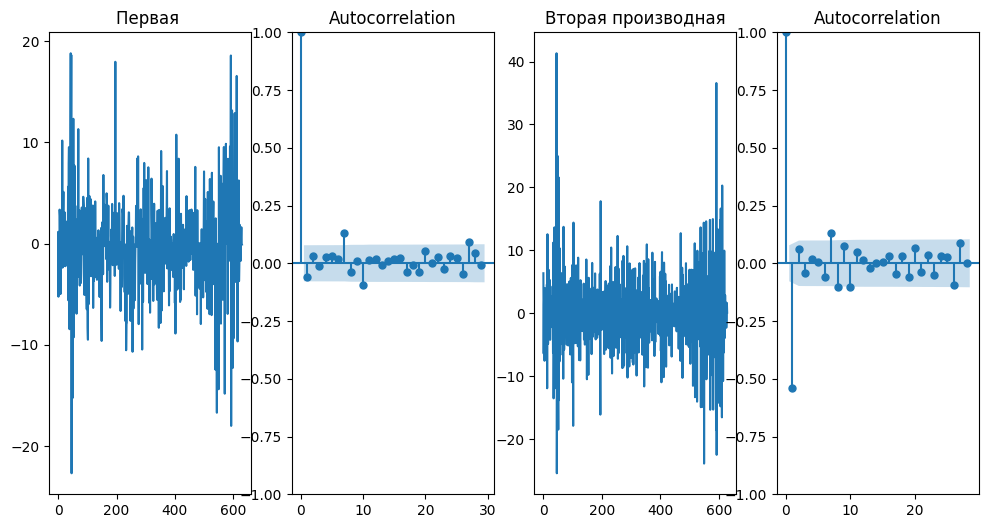

In [9]:
f = plt.figure(figsize=(12,6))
ax1 = f.add_subplot(141)
ax1.set_title("Первая ")
ax1.plot(data["цена"].diff())

ax2 = f.add_subplot(142)
plot_acf(data["цена"].diff().dropna(), ax=ax2)

ax1 = f.add_subplot(143)
ax1.set_title("Вторая производная")
ax1.plot(data["цена"].diff().diff())

ax2 = f.add_subplot(144)
plot_acf(data["цена"].diff().diff().dropna(), ax=ax2)
plt.show()

plt.show()

In [10]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

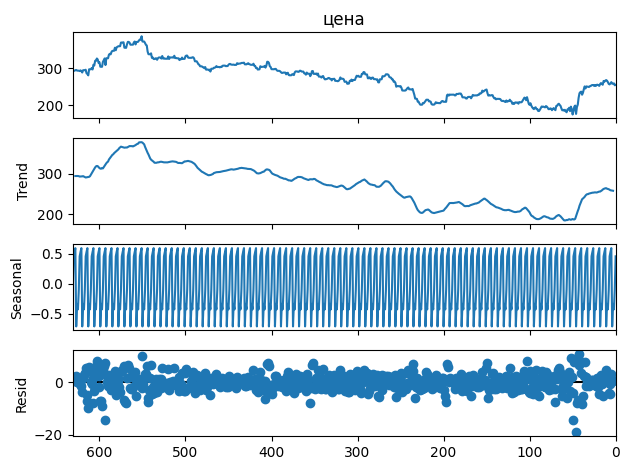

In [12]:
# Проверка точности декомпозиции с периодом 7 (неделя)
decompose_result = seasonal_decompose(data["цена"], period=7)
decompose_result.plot();  #weights=True

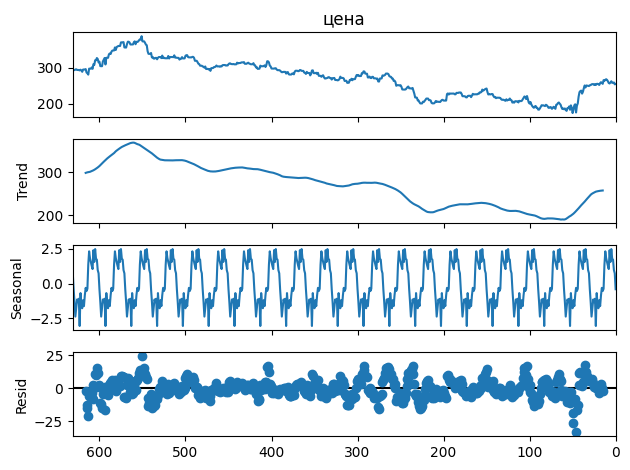

In [13]:
# Проверка точности декомпозиции с периодом 30 (месяц)
decompose_result = seasonal_decompose(data["цена"], period=30)
decompose_result.plot();  #weights=True


Период 7 дней дает очевидно лучшее приближение

In [14]:
data["HW"] = ExponentialSmoothing(data["цена"],
                                  seasonal_periods=7).fit(smoothing_level=1,
                                                           smoothing_trend=0,
                                                          smoothing_seasonal=0).fittedfcast[:-1]

In [15]:
len(decompose_result.seasonal)

632

In [ ]:
# По аналогии с учебными матриалами
# ищем наибольший вклад компоненты в корреляцию по первым двум производным

data_ = data["цена"]
pacf_coeff = np.zeros(29)
for p in range(1, 3):
    data_ = data_.diff() #.dropna()
    pacf_coeff += np.abs(pacf(data_))

pacf_coeff = list(pacf_coeff)
p_best = pacf_coeff.index(max(pacf_coeff))+1
print ("Порядок авторегрессии (AR) равен", p_best)

Порядок авторегрессии (AR) равен 1


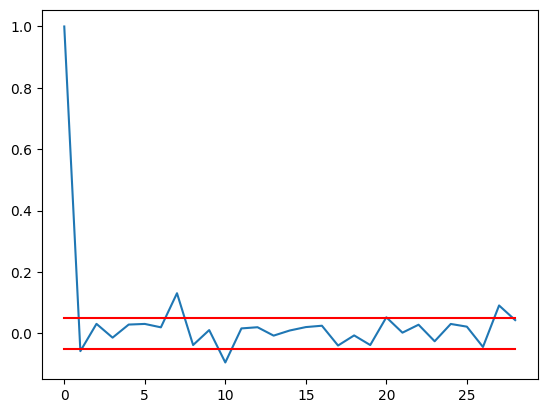

q – порядок скользящего среднего (MA) равен 2


In [ ]:
# ищем порядок скользящего среднего (по вкладу компонентов первой производной)
q_best = 0
result = acf(data["цена"].diff().dropna())
plt.plot(result)
plt.plot([0.05]*len(result), color="red")
plt.plot([-0.05]*len(result), color="red")
plt.show()
for i in range(len(result)):
    if abs(result[i]) > 0.05:
        q_best = i + 1
    else:
        break
print ("q – порядок скользящего среднего (MA) равен", q_best)

## Определениe наиболее релевантных признаков в датасете с использованием методов автоматизированного отбора признаков.

In [16]:
data = data.dropna()
data['datetime'] = pd.to_datetime(data['дата'])
data['delta'] = (data['datetime'] - data['datetime'].min())  / np.timedelta64(1,'D')

# Подготовка данных
X = data.drop(['цена','дата','datetime'], axis=1)
y = data['цена']


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 627 entries, 626 to 0
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   дата      627 non-null    datetime64[ns]
 1   открытие  627 non-null    float64       
 2   макс      627 non-null    float64       
 3   мин       627 non-null    float64       
 4   цена      627 non-null    float64       
 5   день      627 non-null    int64         
 6   wd        627 non-null    int64         
 7   diff1     627 non-null    float64       
 8   цена1     627 non-null    float64       
 9   diff2     627 non-null    float64       
 10  цена2     627 non-null    float64       
 11  diff3     627 non-null    float64       
 12  цена3     627 non-null    float64       
 13  diff4     627 non-null    float64       
 14  цена4     627 non-null    float64       
 15  diff5     627 non-null    float64       
 16  HW        627 non-null    float64       
 17  datetime  627 no

In [18]:
from sklearn.feature_selection import RFE, f_classif, mutual_info_regression, RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.preprocessing import MinMaxScaler

In [19]:
# 1. RFE (Recursive Feature Elimination)
# RFE рекурсивно уменьшает количество признаков, оценивая модель на каждом этапе и выбирая либо лучший, либо худший признак.
estimator = LinearRegression()
selector = RFE(estimator)
selector = selector.fit(X, y)
rfe_features = pd.Series(selector.support_, index=X.columns).apply(lambda x: 1 if x else 0)

# 2. RandomForest
# Случайный лес оценивает важность признаков на основе того, насколько часто каждый признак используется для принятия решений в деревьях.
model_rf = RandomForestRegressor()
model_rf.fit(X, y)
rf_importances = pd.Series(model_rf.feature_importances_, index=X.columns)

# 3. Lasso
# Lasso (линейная регрессия с L1-регуляризацией) может свести вес некоторых признаков к нулю, тем самым исключая их.
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(X, y)
lasso_coefficients = pd.Series(model_lasso.coef_, index=X.columns)

# 4. SFS (Sequential Feature Selector)
# SFS последовательно добавляет или удаляет признаки на основе их производительности до достижения заданного числа признаков.
sfs = SFS(LinearRegression(),
          k_features='best',
          forward=True,
          floating=False,
          scoring='r2',
          cv=5)
sfs.fit(X, y)
sfs_features = pd.Series([1 if i in list(sfs.k_feature_idx_) else 0 for i in range(X.shape[1])], index=X.columns)

# 5. ANOVA
# ANOVA (дисперсионный анализ) проверяет, имеют ли две или более группы схожие средние значения. В контексте отбора признаков это может помочь определить,
# влияет ли признак на целевую переменную.
f_scores, _ = f_classif(X, y)
f_features = pd.Series(f_scores, index=X.columns)

# 6. Mutual Information
# Взаимная информация измеряет зависимость между признаком и целевой переменной; ближе к 0 - меньше зависимости, ближе к 1 - более сильная зависимость.
mi_scores = mutual_info_regression(X, y)
mi_features = pd.Series(mi_scores, index=X.columns)

# 7. RFECV (Recursive Feature Elimination with Cross-Validation)
# RFECV сочетает RFE с кросс-валидацией, чтобы выбрать оптимальное количество признаков.
selector = RFECV(estimator)
selector = selector.fit(X, y)
rfecv_features = pd.Series(selector.support_, index=X.columns).apply(lambda x: 1 if x else 0)

# Сводная таблица
feature_table = pd.DataFrame({
    'RFE': rfe_features,
    'RandomForest': rf_importances,
    'Lasso': lasso_coefficients,
    'SFS': sfs_features,
    'Mutual Info': mi_features,
    'RFECV': rfecv_features
})

# Нормализация данных с весами
scaler = MinMaxScaler()
methods_with_weights = ['RandomForest', 'Lasso', 'Mutual Info']
feature_table[methods_with_weights] = scaler.fit_transform(feature_table[methods_with_weights])

# Расчет общей важности и создание рейтинга
feature_table['Total Importance'] = feature_table.sum(axis=1)
feature_ranking = feature_table.sort_values(by='Total Importance', ascending=False)

feature_ranking

,RFE,RandomForest,Lasso,SFS,Mutual Info,RFECV,Total Importance
цена1,1,4.831501e-02,0.985553,1,0.797089,1,4.830957
diff1,1,2.024521e-04,1.000000,1,0.000000,1,4.000202
макс,0,1.000000e+00,0.589413,1,1.000000,0,3.589413
мин,0,6.976784e-01,0.569019,1,0.991684,0,3.258381
HW,1,9.680950e-03,0.303896,0,0.796930,1,3.110507
цена3,1,1.810620e-04,0.292910,0,0.618545,1,2.911636
diff2,1,2.867842e-05,0.297491,0,0.000000,1,2.297520
цена2,1,1.245024e-03,0.297382,0,0.685240,0,1.983868
открытие,0,1.096665e-02,0.000000,1,0.837718,0,1.848684
diff4,1,3.760289e-07,0.292868,0,0.020887,0,1.313755


Значащими параметрами можно признать: 'цена1','diff1','макс','мин', 'HW' (Total Importance >= 3 )

## Подбор параметров по корреляции

In [28]:
from sklearn.preprocessing import StandardScaler

In [35]:
# Нормирование данных
x_columns = [ 'открытие', 'макс', 'мин', 'цена2', 'цена3', 'цена4', 'wd', 'HW', 'diff1', 'diff2', 'diff3', 'diff4', 'diff5']
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[x_columns][5:])

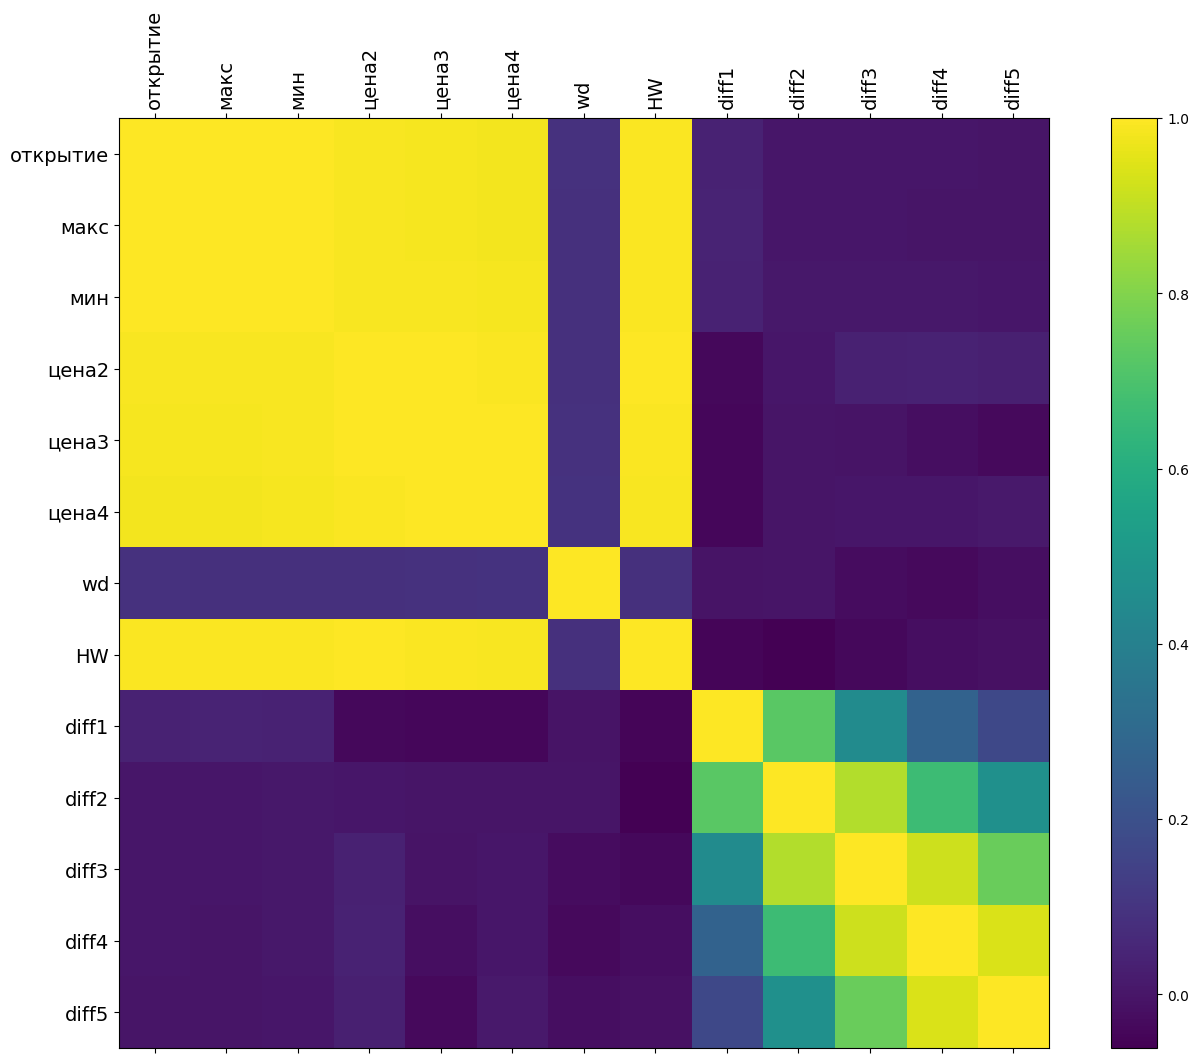

In [37]:
f = plt.figure(figsize=(16, 12))
data_corr = pd.DataFrame(data_scaled).corr()
plt.matshow(data_corr, fignum=f.number)
plt.xticks(range(len(x_columns)), x_columns, fontsize=14, rotation=90)
plt.yticks(range(len(x_columns)), x_columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.show()

In [38]:
feature_list = []
for i,c in enumerate(data_corr[0]):
    if (c>0.5 or c<-0.5) and i>0:
        feature_list.append(x_columns[i])
print ("Перспективные факторы: " + ', '.join(feature_list))

Перспективные факторы: макс, мин, цена2, цена3, цена4, HW


-----

In [20]:
def get_corr_coef(data,        # данные
                  back_steps): # шаг смещения >= 0

    # Получение общих частей исходного и смещенного на back_steps рядов,
    # затем вычисление матрицы коэффициентов и отбор коэффициента из нужного места матрицы
    return np.corrcoef(data[back_steps:], data[:len(data) - back_steps])[0, 1]

In [21]:
def autocorr_graph(data, steps_max):
    # Задание последовательности шагов смещения от 0 до steps_max
    # и расчет коэффициентов автокорреляции для этих смещений
    steps = range(0, steps_max + 1)
    coefs = [get_corr_coef(data, i) for i in steps]

    # Рисование графика коэффициентов автокорреляции
    plt.plot(steps, coefs)
    plt.xticks(steps)
    plt.xlabel('Шаги смещения')
    plt.ylabel('Коэффициент автокорреляции')
    plt.show()

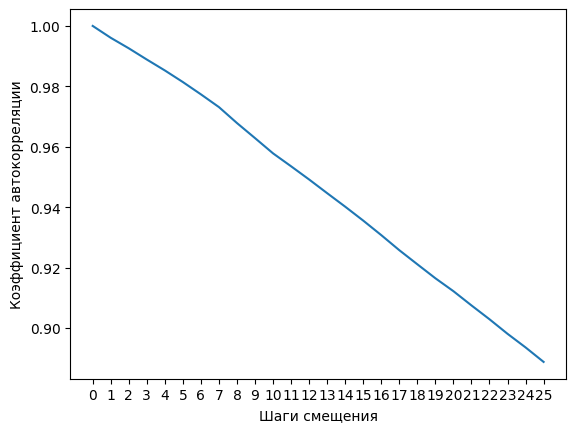

In [22]:
# График коэффициентов автокорреляции
autocorr_graph(data['цена'], 25)

In [23]:
def show_skew(data, back_steps):
    # Построение и вывод общих частей исходного и смещенного рядов
    x_t = data[back_steps:]
    x_t_b = data[:len(data) - back_steps]

    print('Шаги смещения: {}, коэф. автокорреляции: {:.4f}'.format(back_steps,
                                                                   get_corr_coef(data, back_steps)))
#     print(x_t)
#     print(x_t_b)

    # Рисование совместного графика исходного и смещенного временных рядов
    plt.figure(figsize=(12, 6))
    plt.plot(x_t, marker='.', label='Основной ряд')
    plt.plot(x_t_b, label='Смещенный ряд')  #marker='.',
    plt.xlabel('Время')
    plt.ylabel('Данные')
    plt.legend()
    plt.show()

Шаги смещения: 10, коэф. автокорреляции: 0.9578


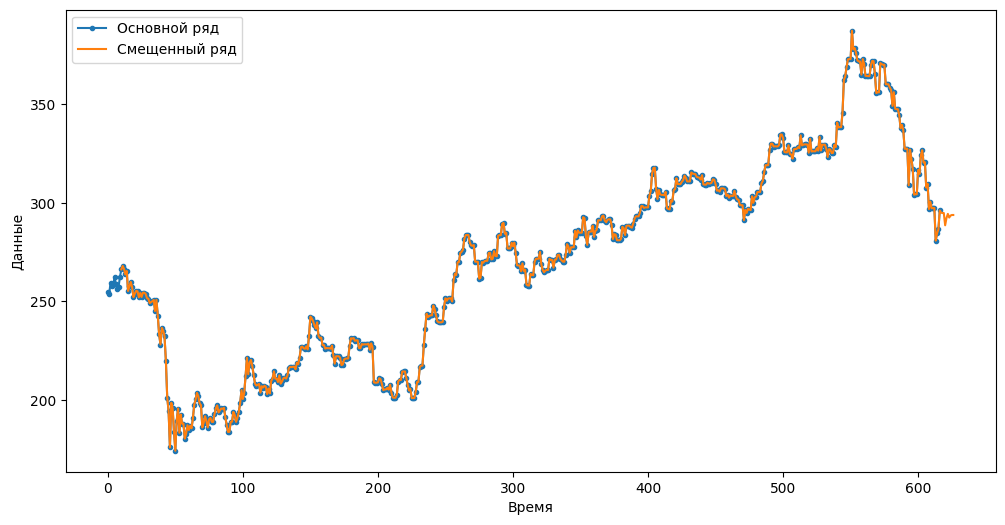

In [24]:
show_skew(data['цена'], 10)

In [25]:
data.shape

(627, 19)

## Строим модель SARIMA

In [ ]:
# coeff_best = (1, 2, 1)
# seasonal_coeff_best = (1, 3, 1, 30)

model = SARIMAX(x[:-30], order=coeff_best, seasonal_order=seasonal_coeff_best).fit()
forecast = model.get_forecast(steps=30).predicted_mean

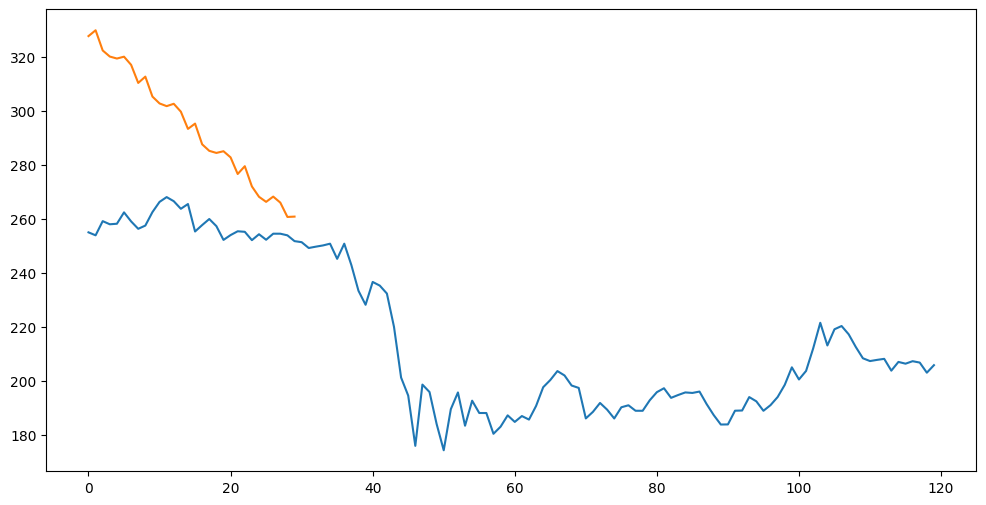

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(x[-120:])
plt.plot(forecast)
plt.show()

In [ ]:
# Оценим ошибку модели
model_smape = smape(x[-30:], forecast)
print ("Ошибка модели:", model_smape)

Ошибка модели: 387.8760292617367


In [ ]:
x = data['цена']

In [ ]:
aic_best = 1e10
coeff_best = (1, 1, 1)
for p in range(1,5):
    for d in range(1,5):
        for q in range(1,5):
            model_ = SARIMAX(x[-100:], order=(p, d, q), seasonal_order=(1, 1, 1, 7)).fit()
            aic = model_.aic
            print ("Тестируем", p, d, q, "результат:", aic)
            if aic < aic_best:
                coeff_best = (p, d, q)
                aic_best = aic
print ("Наилучшие коффициенты:", coeff_best)

Тестируем 1 1 1 результат: 605.6263500637067
Тестируем 1 1 2 результат: 607.2415934394634
Тестируем 1 1 3 результат: 607.6035726629734
Тестируем 1 1 4 результат: 608.8489569503892
Тестируем 1 2 1 результат: 606.8013930408177
Тестируем 1 2 2 результат: 608.7126515560898
Тестируем 1 2 3 результат: 610.6748331025515
Тестируем 1 2 4 результат: 610.6391234535856
Тестируем 1 3 1 результат: 640.677618927652
Тестируем 1 3 2 результат: 613.064172662727
Тестируем 1 3 3 результат: 614.7627093847514
Тестируем 1 3 4 результат: 616.482505914458
Тестируем 1 4 1 результат: 702.2621986836494
Тестируем 1 4 2 результат: 645.0404289009851
Тестируем 1 4 3 результат: 626.3961838614874
Тестируем 1 4 4 результат: 628.0443275009465
Тестируем 2 1 1 результат: 607.0687134601872
Тестируем 2 1 2 результат: 604.9242953206669
Тестируем 2 1 3 результат: 606.7972629731114
Тестируем 2 1 4 результат: 610.8164944383125
Тестируем 2 2 1 результат: 608.3310805402231
Тестируем 2 2 2 результат: 610.2430304747733
Тестируем 2 2

In [ ]:
#подбор сезонных коэффициентов
aic_best = 1e10
seasonal_coeff_best = (1, 1, 1, 30)
for P in range(1,3):
    for D in range(1,4):
        for Q in range(1,3):
            model_ = SARIMAX(x[-100:], order=coeff_best, seasonal_order=(P, D, Q, 7)).fit()
            aic = model_.aic
            print ("Тестируем", P, D, Q, "результат:", aic)
            if aic < aic_best:
                seasonal_coeff_best = (P, D, Q, 7)
                aic_best = aic
print ("Наилучшие сезонные коффициенты:", seasonal_coeff_best)

Тестируем 1 1 1 результат: 604.9242953206669
Тестируем 1 1 2 результат: 606.8796281728506
Тестируем 1 2 1 результат: 604.3287475559598
Тестируем 1 2 2 результат: 604.76725651396
Тестируем 1 3 1 результат: 617.7838528165807
Тестируем 1 3 2 результат: 611.8147115638993
Тестируем 2 1 1 результат: 606.8643237220992
Тестируем 2 1 2 результат: 608.8803967018905
Тестируем 2 2 1 результат: 604.8486630505845
Тестируем 2 2 2 результат: 611.2174790135149
Тестируем 2 3 1 результат: 630.1109351196271
Тестируем 2 3 2 результат: 613.5600991131292
Наилучшие сезонные коффициенты: (1, 2, 1, 7)


# Ансамбль регрессии по остаткам и SARIMAX

In [41]:
data = df.copy()
y = data["цена"]
x = range(0, len(y))

In [42]:
aic_min = 10e10
for i in range(2, 10):
    x_ = PolynomialFeatures(i).fit_transform(np.array(x).reshape(-1, 1))
    m = OLS(y, add_constant(x_)).fit()
    if m.aic < aic_min:
        aic_min = m.aic
    else:
        i -= 1
        break
print ("Наилучшая модель степени", i)
best_power = i

Наилучшая модель степени 5


In [43]:
x_ = PolynomialFeatures(best_power).fit_transform(np.array(x).reshape(-1, 1))
model_trend = OLS(y, add_constant(x_)).fit()
prediction_trend = model_trend.predict(x_)
print(y.shape, prediction_trend.shape)

(632,) (632,)


In [44]:
model_smape = smape(y[-10:], prediction_trend[-10:])
print ("Ошибка модели2:", model_smape)

Ошибка модели2: 16.036844552445185


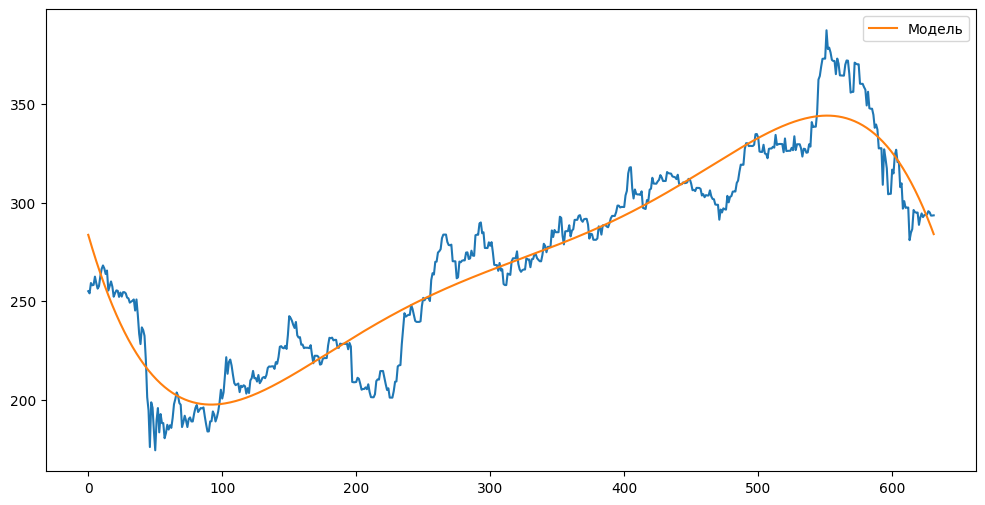

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(y)
plt.plot(prediction_trend, label="Модель")
plt.legend()
plt.show()

### Остатки

In [46]:
x_res = y - prediction_trend

Используем период = 7 

In [48]:
aic_best = 1e10
coeff_best = (1, 1, 1)
for p in range(1,3):
    for d in range(1,3):
        for q in range(1,3):
            model_ = SARIMAX(x_res, order=(p, d, q), seasonal_order=(1, 1, 1, 7)).fit()
            aic = model_.aic
            if aic < aic_best:
                coeff_best = (p, d, q)
                aic_best = aic
print ("Наилучшие коффициенты:", coeff_best)

Наилучшие коффициенты: (2, 1, 2)


In [49]:
seasonal_coeff_best = (1, 1, 1, 7)
for P in range(1,3):
    for D in range(1,3):
        for Q in range(1,3):
            model_ = SARIMAX(x_res, order=coeff_best, seasonal_order=(P, D, Q, 7)).fit()
            aic = model_.aic
            if aic < aic_best:
                seasonal_coeff_best = (P, D, Q, 7)
                aic_best = aic
print ("Наилучшие сезонные коффициенты:", seasonal_coeff_best)

Наилучшие сезонные коффициенты: (1, 1, 1, 7)


In [50]:
# Визуализация результата

In [51]:
model = SARIMAX(x_res[:-10], order=coeff_best, seasonal_order=seasonal_coeff_best).fit()
forecast = model.get_forecast(steps=10).predicted_mean
print(forecast.shape)

(10,)


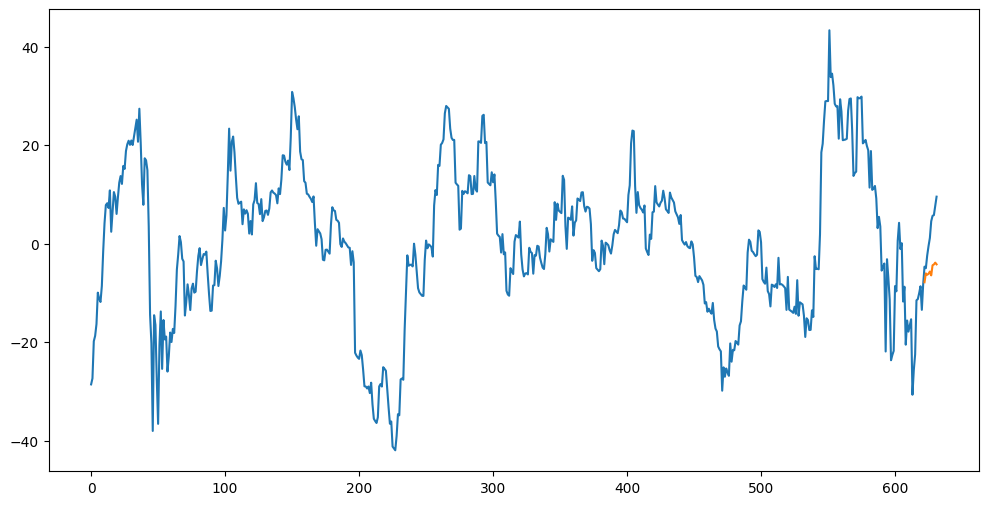

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(x_res)
plt.plot(forecast)
plt.show()

In [53]:
model_smape = smape(x_res[-7:], forecast)
print ("Ошибка модели:", model_smape)

Ошибка модели: 1369.5127830104475


### Предсказание на 2022 год
По полиномиальной регрессии и остаткам вместе


In [54]:
x_2022 = range(0, len(y)+10)
x_2022_ = PolynomialFeatures(best_power).fit_transform(np.array(x_2022).reshape(-1, 1))
prediction_trend = model_trend.predict(x_2022_[-10:])
print (prediction_trend)
print (prediction_trend.shape)


[282.10267581 280.19903991 278.25726585 276.27691897 274.25756158
 272.19875298 270.10004947 267.96100428 265.78116762 263.56008665]
(10,)


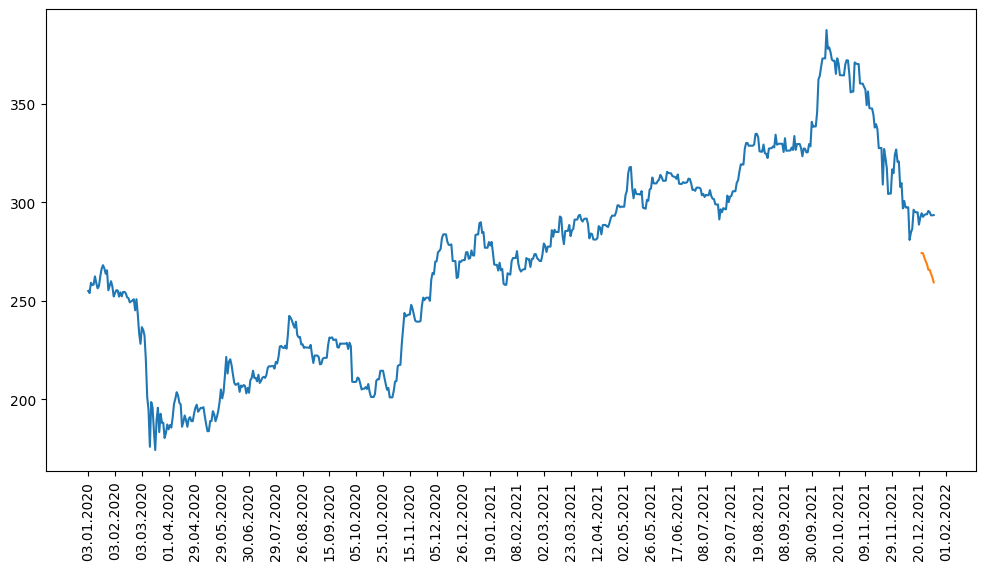

In [55]:
prediction = prediction_trend + forecast
plt.figure(figsize=(12, 6))
plt.plot(y)
plt.plot(prediction)
plt.xticks(range(0, len(data)+11, 20),
           list(data['дата'][::20].values) + ['01.02.2022'], rotation="vertical")
plt.show()

In [56]:
model_smape = smape(y[-7:], prediction)
print ("Ошибка модели:", model_smape)

Ошибка модели: 72.83751876548715


## Чистая SARIMAX

In [57]:
aic_best = 1e10
coeff_best2 = (1, 1, 1)
for p in range(1,3):
    for d in range(1,3):
        for q in range(1,3):
            model_ = SARIMAX(y, order=(p, d, q), seasonal_order=(1, 1, 1, 12)).fit()
            aic = model_.aic
            if aic < aic_best:
                coeff_best2 = (p, d, q)
                aic_best = aic
print ("Наилучшие коффициенты:", coeff_best2)

Наилучшие коффициенты: (1, 1, 1)


In [58]:
seasonal_coeff_best2 = (1, 1, 1, 7)
for P in range(1,3):
    for D in range(1,3):
        for Q in range(1,3):
            model_ = SARIMAX(x_res, order=coeff_best2, seasonal_order=(P, D, Q, 7)).fit()
            aic = model_.aic
            if aic < aic_best:
                seasonal_coeff_best2 = (P, D, Q, 7)
                aic_best = aic
print ("Наилучшие сезонные коффициенты:", seasonal_coeff_best2)

Наилучшие сезонные коффициенты: (1, 1, 1, 7)


In [59]:
model2 = SARIMAX(y[:-10], order=coeff_best2, seasonal_order=seasonal_coeff_best2).fit()
forecast2 = model2.get_forecast(steps=10).predicted_mean
model2_smape = smape(y[-10:], forecast2)
print ("Ошибка модели2:", model2_smape)

Ошибка модели2: 3.905024019550981


In [60]:
model2_1 = SARIMAX(y, order=coeff_best2, seasonal_order=seasonal_coeff_best2).fit()
forecast2_1 = model2_1.get_forecast(steps=11).predicted_mean
print (forecast2_1)
print(forecast2_1.shape)
model2_smape = smape(y[-10:], forecast2)
print ("Ошибка модели2:", model2_smape)

632    293.140284
633    293.172347
634    293.027658
635    294.132169
636    294.022407
637    294.091989
638    293.730991
639    293.310168
640    293.341642
641    292.969773
642    294.286419
Name: predicted_mean, dtype: float64
(11,)
Ошибка модели2: 3.905024019550981


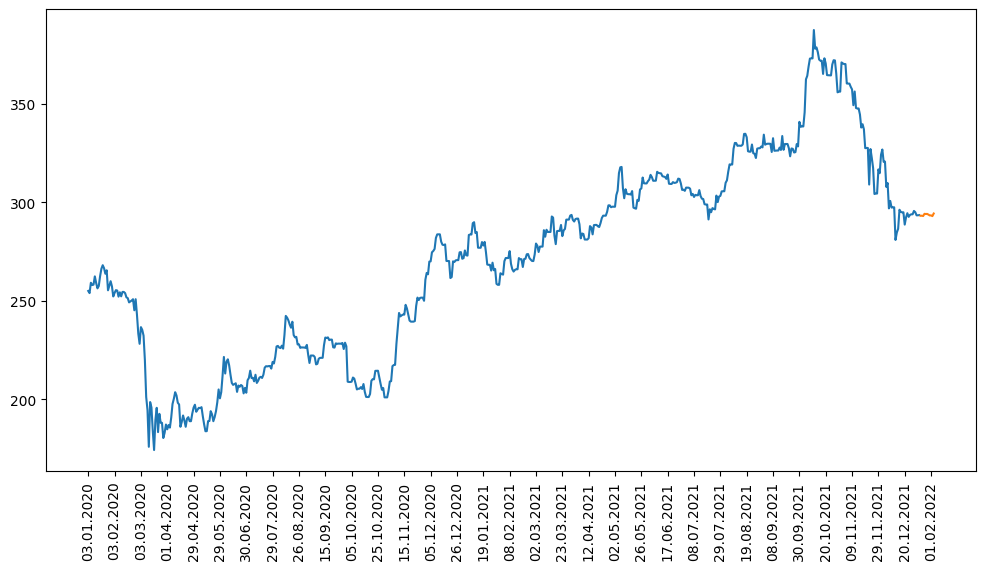

In [61]:
plt.figure(figsize=(12, 6))
plt.plot(y)
plt.plot(forecast2_1)
plt.xticks(range(0, len(data)+11, 20),
           list(data['дата'][::20].values) + ['01.02.2022'], rotation="vertical")
plt.show()

### Ансамбль: усредняем предсказание моделей¶
Веса выбираем обратно пропорционально ошибке предсказания последних 10 значений по SMAPE


In [62]:
forecast_ensemble = (model2_smape * prediction_trend[-11:] + model_smape * forecast2)/(model2_smape + model_smape)
print (forecast_ensemble)

622    292.060973
623    293.385010
624    292.752400
625    292.163029
626    292.030118
627    290.735907
628    292.226087
629    292.295579
630    292.533355
631    291.996207
Name: predicted_mean, dtype: float64


In [63]:
print ("Ошибка ансамбля:", smape(y[-10:], forecast_ensemble))

Ошибка ансамбля: 6.359248722899648


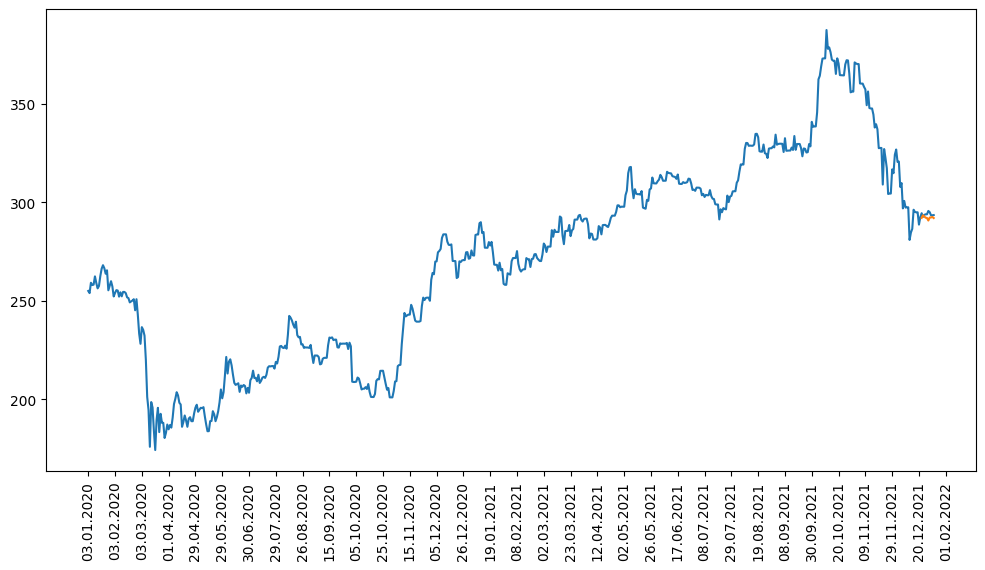

In [64]:
plt.figure(figsize=(12, 6))
plt.plot(y)
plt.plot(forecast_ensemble)
plt.xticks(range(0, len(data)+11, 20),
           list(data['дата'][::20].values) + ['01.02.2022'], rotation="vertical")
plt.show()